In [ ]:
# center_coordinates_train and _val were obtained in preprocessing UNet
center_coordinates_train = [[ 93.0  , 112.0 ],[ 126.0  , 131.0 ],[ 79.0  , 127.0 ],[ 89.0  , 139.0 ],[ 85.0  , 126.0 ],[ 83.0  , 126.0 ],[ 85.0  , 137.0 ],[ 101.0  , 147.0 ],[ 104.0  , 134.0 ],[ 92.0  , 137.0 ],[ 86.0  , 138.0 ],[ 107.0  , 127.0 ],[ 85.0  , 135.0 ],[ 71.0  , 138.0 ],[ 119.0  , 92.0 ],[ 116.0  , 146.0 ],[ 115.0  , 92.0 ],[ 89.0  , 119.0 ],[ 94.0  , 128.0 ],[ 109.0  , 151.0 ],[ 82.0  , 137.0 ],[ 98.0  , 145.0 ],[ 92.0  , 133.0 ],[ 82.0  , 125.0 ],[ 80.0  , 153.0 ],[ 116.0  , 151.0 ],[ 120.0  , 68.0 ],[ 87.0  , 133.0 ],[ 111.0  , 76.0 ],[ 98.0  , 78.0 ],[ 106.0  , 110.0 ],[ 111.0  , 83.0 ],[ 99.0  , 122.0 ],[ 92.0  , 146.0 ],[ 85.0  , 126.0 ],[ 69.0  , 150.0 ],[ 124.0  , 140.0 ],[ 112.0  , 114.0 ],[ 129.0  , 159.0 ],[ 76.0  , 138.0 ],[ 88.0  , 123.0 ],[ 80.0  , 130.0 ],[ 116.0  , 89.0 ],[ 111.0  , 97.0 ],[ 112.0  , 144.0 ],[ 145.0  , 101.0 ],[ 170.0  , 101.0 ],[ 98.0  , 136.0 ],[ 109.0  , 91.0 ],[ 86.0  , 106.0 ],[ 118.0  , 159.0 ],[ 113.0  , 130.0 ],[ 114.0  , 93.0 ],[ 121.0  , 102.0 ],[ 73.0  , 141.0 ],[ 79.0  , 147.0 ],[ 122.0  , 129.0 ],[ 92.0  , 152.0 ],[ 76.0  , 116.0 ],[ 75.0  , 134.0 ],[ 87.0  , 146.0 ],[ 66.0  , 125.0 ],[ 62.0  , 88.0 ],[ 90.0  , 124.0 ],[ 95.0  , 120.0 ],[ 82.0  , 118.0 ],[ 88.0  , 110.0 ],[ 109.0  , 136.0 ],[ 106.0  , 133.0 ],[ 108.0  , 72.0 ],[ 78.0  , 119.0 ],[ 71.0  , 135.0 ],[ 117.0  , 69.0 ],[ 95.0  , 138.0 ],[ 121.0  , 146.0 ],[ 84.0  , 130.0 ],[ 104.0  , 135.0 ],[ 122.0  , 77.0 ],[ 79.0  , 122.0 ],[ 104.0  , 130.0 ]]

center_coordinates_val = [[ 92.0  , 100.0 ],[ 82.0  , 148.0 ],[ 81.0  , 121.0 ],[ 100.0  , 62.0 ],[ 90.0  , 132.0 ],[ 100.0  , 130.0 ],[ 93.0  , 124.0 ],[ 73.0  , 134.0 ],[ 77.0  , 112.0 ],[ 102.0  , 139.0 ],[ 90.0  , 130.0 ],[ 99.0  , 125.0 ],[ 122.0  , 129.0 ],[ 104.0  , 131.0 ],[ 88.0  , 111.0 ],[ 114.0  , 95.0 ],[ 91.0  , 133.0 ],[ 71.0  , 119.0 ],[ 101.0  , 122.0 ],[ 115.0  , 138.0 ]]


In [ ]:
# print length of train and val center coordinates to check whether its length is the same as the train and val split
print('Length of train center coordinates: ', len(center_coordinates_train))
print('Length of validation center coordinates: ', len(center_coordinates_val))

Length of train center coordinates:  80
Length of validation center coordinates:  20


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp /content/drive/MyDrive/COLAB/DL_3D_MIA_project/metrics_acdc.py /content

!pip install SimpleITK
!pip install nibabel
!pip install medpy
!pip install monai
import SimpleITK as sitk
import nibabel as nib
import monai

import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import glob

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

from metrics_acdc import load_nii

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'The used device is {device}')

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48.4 MB 1.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 151 kB 4.7 MB/s 
  Created wheel for medpy: filename=MedPy-0.4.0-cp37-cp37m-linux_x86_64.whl size=754475 sha256=0ed7d1b7ec0473658f717c067ae5f20ffd587720b3c8726bc781b5e50dbb6568
  Stored in directory: /root/.cache/pip/wheels/b0/57/3a/da1183f22a6afb42e11138daa6a759de233fd977a984333602
Successfully built medpy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 939 kB 4.9 MB/s 
The used device is cuda


# Construct the dictionary of file paths

In [ ]:
# split of dataset in train and val must be based on patients (not on image slices)
# use seed for random_state so that the method is reproducible
train_patient, validation_patient = train_test_split(range(1,101), train_size=0.8, random_state=42)
print('Patient numbers in train dataset: ', train_patient)
print('Patient numbers in validation dataset: ', validation_patient)

def build_dict_acdc(data_path, prediction_path, mode='train'):
    """
    This function returns a list of dictionaries, each dictionary containing the keys 'img' and 'mask' 
    that returns the path to the corresponding image.
    
    Args:
        data_path (str): path to the root folder of the data set.
        mode (str): subset used. Must correspond to 'train', 'val' or 'test'.
        
    Returns:
        (List[Dict[str, str]]) list of the dictionaries containing the paths of images and masks.
    """
    # test if mode is correct
    if mode not in ["train", "val", "test"]:
        raise ValueError(f"Please choose a mode in ['train', 'val', 'test']. Current mode is {mode}.")
    
    # define empty dictionary
    dicts = []
    target = train_patient if mode == "train" else validation_patient 
    # make a corresponding list for all the mask files
    for patient_nb in target:
        # set patient_path
        patient_path = os.path.join(data_path, 'patient'+'{0:03}'.format(patient_nb))

        # extract ED and ES frame number from patient info
        patient_info = os.path.join(patient_path, 'Info.cfg')
        file = open(patient_info, 'r').readlines()
        ED_frame = int(file[0].split(':')[1])
        ES_frame = int(file[1].split(':')[1])

        # set image and mask paths
        image_path = []
        image_path.append(os.path.join(patient_path, 'patient'+'{0:03}'.format(patient_nb)+'_frame'+'{0:02}'.format(ED_frame)+'.nii.gz'))
        image_path.append(os.path.join(patient_path, 'patient'+'{0:03}'.format(patient_nb)+'_frame'+'{0:02}'.format(ES_frame)+'.nii.gz'))

        mask_path = []
        mask_path.append(os.path.join(patient_path, 'patient'+'{0:03}'.format(patient_nb)+'_frame'+'{0:02}'.format(ED_frame)+'_gt.nii.gz'))
        mask_path.append(os.path.join(patient_path, 'patient'+'{0:03}'.format(patient_nb)+'_frame'+'{0:02}'.format(ES_frame)+'_gt.nii.gz'))

        prediction_preprocessing_path = []
        prediction_preprocessing_path.append(os.path.join(prediction_path,'predicted_segmentation_patient'+str(patient_nb)+'.npy'))
        prediction_preprocessing_path.append(os.path.join(prediction_path,'predicted_segmentation_patient'+str(patient_nb)+'.npy'))

        dicts.append({'img': image_path, 'mask': mask_path, 'prediction_preprocessing': prediction_preprocessing_path})
    return dicts


Patient numbers in train dataset:  [56, 89, 27, 43, 70, 16, 41, 97, 10, 73, 12, 48, 86, 29, 94, 6, 67, 66, 36, 17, 50, 35, 8, 96, 28, 20, 82, 26, 63, 14, 25, 4, 18, 39, 9, 79, 7, 65, 37, 90, 57, 100, 55, 44, 51, 68, 47, 69, 62, 98, 80, 42, 59, 49, 99, 58, 76, 33, 95, 60, 64, 85, 38, 30, 2, 53, 22, 3, 24, 88, 92, 75, 87, 83, 21, 61, 72, 15, 93, 52]
Patient numbers in validation dataset:  [84, 54, 71, 46, 45, 40, 23, 81, 11, 1, 19, 31, 74, 34, 91, 5, 77, 78, 13, 32]


In [ ]:
# build dict of ACDC data
data_path = r'/content/drive/My Drive/COLAB/DL_3D_MIA_project/data/ACDC/training'
prediction_preprocessing_path = r'/content/drive/My Drive/COLAB/DL_3D_MIA_project/predictions/preprocessing'

train_dict_list = build_dict_acdc(data_path, prediction_preprocessing_path, mode='train')
val_dict_list = build_dict_acdc(data_path, prediction_preprocessing_path, mode='val')

# Define a function that loads the ACDC dataset

In [ ]:
class LoadACDCData(monai.transforms.Transform):
    """
    This custom Monai transform loads the data from the acdc segmentation dataset.
    """
    def __init__(self, keys=None):
        pass

    def __call__(self, sample):
        # LOAD END DIASTOLIC (ED) IMAGES - NOT END SYSTOLIC (ES) IMAGES
        image_ED = load_nii(sample['img'][0])
        image = image_ED[0]
        # image_ES = load_nii(sample['img'][1])
        # image = image_ES[0]
        _, image_ED_aff, image_ED_header = load_nii(sample['img'][0])
        # set pixel dimensions in image_ED_aff
        image_ED_aff[0,0] = -image_ED_header['pixdim'][1]
        image_ED_aff[1,1] = -image_ED_header['pixdim'][2]
        image_ED_aff[2,2] = image_ED_header['pixdim'][3]

        # LOAD END DIASTOLIC (ED) MASKS - NOT END SYSTOLIC (ES) MASKS
        mask_ED = load_nii(sample['mask'][0])
        mask = mask_ED[0]
        # mask_ES = load_nii(sample['mask'][1])
        # mask = mask_ES[0]
        _, mask_ED_aff, mask_ED_header = load_nii(sample['mask'][0])
        # set pixel dimensions in image_ED_aff
        mask_ED_aff[0,0] = -mask_ED_header['pixdim'][1]
        mask_ED_aff[1,1] = -mask_ED_header['pixdim'][2]
        mask_ED_aff[2,2] = mask_ED_header['pixdim'][3]

        prediction_preprocessing = np.load(sample['prediction_preprocessing'][0])

        return {'img': image, 'mask': mask, 'prediction_preprocessing': prediction_preprocessing, 
                'img_meta_dict': {'affine': image_ED_aff, 'pixdim': image_ED_header['pixdim']},
                'mask_meta_dict': {'affine': mask_ED_aff, 'pixdim': mask_ED_header['pixdim']}}

In [ ]:
# create dataset with cache mechanism that can load data and cache deterministic transforms’ result during training
train_dataset = monai.data.CacheDataset(train_dict_list, transform=LoadACDCData())
val_dataset = monai.data.CacheDataset(val_dict_list, transform=LoadACDCData())


Loading dataset: 100%|██████████| 20/20 [00:15<00:00,  1.31it/s]


In [ ]:
# print shapes of images and masks in the validation dataset
# also print the predicted segmentations of the preprocessing model 
# note that the predictions are still transformed and therefore have a different shape than the images and masks
i=0
for sample in val_dataset:
    i=i+1
    image = sample["img"]
    mask = sample["mask"]
    prediction_preprocessing = sample["prediction_preprocessing"]
    pixdim = sample["img_meta_dict"]['pixdim']
    affine = sample["img_meta_dict"]['affine']
    print(i, ": Image size: ", image.shape, "Mask size: ", mask.shape, "Prediction preprocessing size: ", prediction_preprocessing.shape)

1 : Image size:  (208, 256, 12) Mask size:  (208, 256, 12) Prediction preprocessing size:  (190, 233)
2 : Image size:  (216, 256, 8) Mask size:  (216, 256, 8) Prediction preprocessing size:  (214, 253)
3 : Image size:  (192, 256, 10) Mask size:  (192, 256, 10) Prediction preprocessing size:  (200, 267)
4 : Image size:  (256, 216, 9) Mask size:  (256, 216, 9) Prediction preprocessing size:  (267, 225)
5 : Image size:  (208, 256, 8) Mask size:  (208, 256, 8) Prediction preprocessing size:  (217, 267)
6 : Image size:  (208, 256, 10) Mask size:  (208, 256, 10) Prediction preprocessing size:  (206, 253)
7 : Image size:  (216, 256, 9) Mask size:  (216, 256, 9) Prediction preprocessing size:  (208, 247)
8 : Image size:  (154, 224, 17) Mask size:  (154, 224, 17) Prediction preprocessing size:  (169, 247)
9 : Image size:  (216, 256, 9) Mask size:  (216, 256, 9) Prediction preprocessing size:  (214, 253)
10 : Image size:  (216, 256, 10) Mask size:  (216, 256, 10) Prediction preprocessing size:  

# Apply transforms to the train and validation datasets

In [ ]:
# function to convert the labels to multi channels
class ConvertToMultiChanneld(monai.transforms.MapTransform):
    """
    Convert labels to multi channels based on acdc classes:
    label 0 is the background
    label 1 is the right ventricle
    label 2 is is the myocardium
    label 3 is is the left ventricle

    Adapted from https://notebooks.githubusercontent.com/view/ipynb?browser=chrome&color_mode=auto&commit=ef59c3794adbed5d929132f9dc51968580de5141&device=unknown&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f50726f6a6563742d4d4f4e41492f7475746f7269616c732f656635396333373934616462656435643932393133326639646335313936383538306465353134312f33645f7365676d656e746174696f6e2f62726174735f7365676d656e746174696f6e5f33642e6970796e62&logged_in=false&nwo=Project-MONAI%2Ftutorials&path=3d_segmentation%2Fbrats_segmentation_3d.ipynb&platform=android&repository_id=288774122&repository_type=Repository&version=99
    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # label 0 is the background
            result.append(d[key] == 0)
            # label 1 is the right ventricle
            result.append(d[key] == 1)
            # label 2 is the myocardium
            result.append(d[key] == 2)
            # label 3 is the left ventricle
            result.append(d[key] == 3)
            d[key] = np.stack(result, axis=0).astype(np.float32)
        return d

In [ ]:
# compose the transforms that need to be applied to the train and validation dataset
train_transform = monai.transforms.Compose(
    [
        LoadACDCData(),
        monai.transforms.AddChanneld(keys=['img']),
        ConvertToMultiChanneld(keys='mask'),
        monai.transforms.ScaleIntensityRangePercentilesd(keys=['img'], lower=5, upper=95, b_min=0, b_max=1),
        monai.transforms.Spacingd(keys=['img', 'mask'], 
                                  pixdim=(1.5, 1.5, 10), 
                                  mode=("bilinear", "nearest"))
    ]
)

In [ ]:
# create train dataset with cache mechanism and apply train_transforms
train_dataset_transformed = monai.data.CacheDataset(train_dict_list, transform=train_transform)
# use same transform for validation set
val_dataset_transformed = monai.data.CacheDataset(val_dict_list, transform=train_transform)

Loading dataset: 100%|██████████| 20/20 [00:04<00:00,  4.98it/s]


In [ ]:
# print shapes of images and masks in the validation dataset
# also print the predicted segmentations of the preprocessing model 
# note that the images and masks are transformed and now have the same shape (in 2D plane) as the predicted segmentations
# also note that the masks now have four channels
i=0
for sample in val_dataset_transformed:
    i=i+1
    image = sample["img"]
    mask = sample["mask"]
    prediction_preprocessing = sample["prediction_preprocessing"]
    pixdim = sample["img_meta_dict"]['pixdim']
    affine = sample["img_meta_dict"]['affine']
    print(i, ": Image size: ", image.shape, "Mask size: ", mask.shape, "Prediction preprocessing size: ", prediction_preprocessing.shape)

1 : Image size:  (1, 190, 233, 6) Mask size:  (4, 190, 233, 6) Prediction preprocessing size:  (190, 233)
2 : Image size:  (1, 214, 253, 8) Mask size:  (4, 214, 253, 8) Prediction preprocessing size:  (214, 253)
3 : Image size:  (1, 200, 267, 10) Mask size:  (4, 200, 267, 10) Prediction preprocessing size:  (200, 267)
4 : Image size:  (1, 267, 225, 9) Mask size:  (4, 267, 225, 9) Prediction preprocessing size:  (267, 225)
5 : Image size:  (1, 217, 267, 8) Mask size:  (4, 217, 267, 8) Prediction preprocessing size:  (217, 267)
6 : Image size:  (1, 206, 253, 10) Mask size:  (4, 206, 253, 10) Prediction preprocessing size:  (206, 253)
7 : Image size:  (1, 208, 247, 9) Mask size:  (4, 208, 247, 9) Prediction preprocessing size:  (208, 247)
8 : Image size:  (1, 169, 247, 9) Mask size:  (4, 169, 247, 9) Prediction preprocessing size:  (169, 247)
9 : Image size:  (1, 214, 253, 9) Mask size:  (4, 214, 253, 9) Prediction preprocessing size:  (214, 253)
10 : Image size:  (1, 225, 267, 10) Mask s

In [ ]:
plot all channels of the masks of the first sample in val_dataset_transformed
plt.figure()
plt.imshow(val_dataset_transformed[0]['mask'][0,:,:,4].transpose())
plt.show()

plt.figure()
plt.imshow(val_dataset_transformed[0]['mask'][1,:,:,4].transpose())
plt.show()

plt.figure()
plt.imshow(val_dataset_transformed[0]['mask'][2,:,:,4].transpose())
plt.show()

plt.figure()
plt.imshow(val_dataset_transformed[0]['mask'][3,:,:,4].transpose())
plt.show()

# Change transformed dataset from 3D to 2D
and crop region-of-interest (ROI) using center coordinates

In [ ]:
# change 3D dataset to 2D dataset
# and crop region-of-interest (ROI) using center coordinates
def change_dataset_from_3D_to_2D(dataset_3D, center_coordinates):
  samples = []
  for j, sample_3D in enumerate(dataset_3D):
    image_3D = sample_3D['img']
    mask_3D = sample_3D['mask']
    for i in range(image_3D.shape[3]):
      center_coordinates_i = center_coordinates[j]
      crop_transform = monai.transforms.SpatialCrop(roi_center=(int(center_coordinates_i[0]), int(center_coordinates_i[1])),
                                                    roi_size=(128, 128))

      sample_2D = {}
      sample_2D['img'] = crop_transform(image_3D[:,:,:,i])
      sample_2D['mask'] = crop_transform(mask_3D[:,:,:,i])
      samples.append(sample_2D)

  return samples


In [ ]:
train_dataset_2D = change_dataset_from_3D_to_2D(train_dataset_transformed, center_coordinates_train)
print('Size of 2D training dataset: ', len(train_dataset_2D))
val_dataset_2D = change_dataset_from_3D_to_2D(val_dataset_transformed, center_coordinates_val)
print('Size of 2D validation dataset: ', len(val_dataset_2D))
# note that the sizes of the datasets are much larger
# that is because the dataset contains all 2D slices instead of 3D volumes

# print shapes of images and masks in the validation dataset
i=0
for sample in val_dataset_2D:
    i=i+1
    image = sample["img"]
    mask = sample["mask"]
    print(i, ": Image size: ", image.shape, "Mask size: ", mask.shape)
    # plt.figure()
    # plt.imshow(mask[0,:,:].transpose())
    # plt.show()


Size of 2D training dataset:  681
Size of 2D validation dataset:  181
1 : Image size:  (1, 128, 128) Mask size:  (4, 128, 128)
2 : Image size:  (1, 128, 128) Mask size:  (4, 128, 128)
3 : Image size:  (1, 128, 128) Mask size:  (4, 128, 128)
4 : Image size:  (1, 128, 128) Mask size:  (4, 128, 128)
5 : Image size:  (1, 128, 128) Mask size:  (4, 128, 128)
6 : Image size:  (1, 128, 128) Mask size:  (4, 128, 128)
7 : Image size:  (1, 128, 128) Mask size:  (4, 128, 128)
8 : Image size:  (1, 128, 128) Mask size:  (4, 128, 128)
9 : Image size:  (1, 128, 128) Mask size:  (4, 128, 128)
10 : Image size:  (1, 128, 128) Mask size:  (4, 128, 128)
11 : Image size:  (1, 128, 128) Mask size:  (4, 128, 128)
12 : Image size:  (1, 128, 128) Mask size:  (4, 128, 128)
13 : Image size:  (1, 128, 128) Mask size:  (4, 128, 128)
14 : Image size:  (1, 128, 128) Mask size:  (4, 128, 128)
15 : Image size:  (1, 128, 128) Mask size:  (4, 128, 128)
16 : Image size:  (1, 128, 128) Mask size:  (4, 128, 128)
17 : Image 

# Create dataloader for train and validation dataset

In [ ]:
train_dataloader = monai.data.DataLoader(train_dataset_2D, batch_size=16, shuffle=True)
val_dataloader = monai.data.DataLoader(val_dataset_2D, batch_size=16, shuffle=True)


# Setting up the main neural network

In [ ]:
import torch
import torch.nn as nn

from typing import Any, Optional, Sequence, Tuple, Union

from monai.networks.blocks.convolutions import Convolution, ResidualUnit, ADN
from monai.networks.layers.factories import Act, Norm
from monai.networks.layers.simplelayers import SkipConnection
from monai.utils import alias, deprecated_arg

class CNN(nn.Module):
    
    def __init__(
        self,
        spatial_dims: int,
        in_channels: int,
        out_channels: int,
        kernel_size: Union[Sequence[int], int] = 3,
    ) -> None:

        super().__init__()

        self.conv1 = Convolution(
          spatial_dims=2,
          kernel_size=9,
          in_channels=1,
          out_channels=16,
          adn_ordering="NDA",
          act="relu",
          norm="batch",
          dilation=1,
          # dropout=0.1,
          # dropout_dim=2   # dropout random feature maps, instead of random pixels (dropout_dim=1)
        )
        self.conv2 = Convolution(
          spatial_dims=2,
          kernel_size=7,
          in_channels=16,
          out_channels=64,
          adn_ordering="NDA",
          act="relu",
          norm="batch",
          dilation=2,
          # dropout=0.1,
          # dropout_dim=2
        )
        self.conv3 = Convolution(
          spatial_dims=2,
          kernel_size=5,
          in_channels=64,
          out_channels=64,
          adn_ordering="NDA",
          act="relu",
          norm="batch",
          dilation=4,
          # dropout=0.1,
          # dropout_dim=2
        )
        self.conv4 = Convolution(
          spatial_dims=2,
          kernel_size=3,
          in_channels=64,
          out_channels=64,
          adn_ordering="NDA",
          act="relu",
          norm="batch",
          dilation=6,
          # dropout=0.1,
          # dropout_dim=2
        )
        self.conv5 = Convolution(
          spatial_dims=2,
          kernel_size=3,
          in_channels=64,
          out_channels=4,
          adn_ordering="NDA",
          act=None,
          norm="batch",
          dilation=8
        )
        self.final = torch.nn.Softmax()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        #x = self.model(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.final(x)

        return x

model = CNN(
    spatial_dims=2,
    in_channels=1,
    out_channels=4,
).to(device)

# softmax is set to false because this was already done in the network, softmax must only be used once
loss_function = monai.losses.DiceLoss(softmax=False, batch=True)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# print(model)

In [ ]:
import tqdm

def train_acdc(model, train_dataloader, val_dataloader, optimizer, epochs):
    training_loss = []
    validation_loss = []

    for epoch in range(epochs):
        model.train()    
        epoch_loss = 0
        step = 0
        for batch_data in train_dataloader: 
            step += 1
            optimizer.zero_grad()
            outputs = model(batch_data['img'].float().to(device))
            loss = loss_function(outputs, batch_data['mask'].to(device))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        training_loss.append(epoch_loss/step)
        # validation part
        step = 0
        val_loss = 0
        for batch_data in val_dataloader:
            step += 1
            model.eval()
            outputs = model(batch_data['img'].float().to(device))
            loss = loss_function(outputs, batch_data['mask'].to(device))
            val_loss += loss.item()
        validation_loss.append(val_loss/step)
        print('epoch:', epoch+1, ' training loss:', training_loss[-1], ' validation loss:', validation_loss[-1])

    # Store the network parameters        
    torch.save(model.state_dict(), r'trainedCNN.pt')

    return model, training_loss, validation_loss

In [ ]:
n_epochs = 150
model, train_loss, val_loss = train_acdc(model, train_dataloader, val_dataloader, optimizer, epochs=n_epochs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch: 1  training loss: 0.6887275590453037  validation loss: 0.6641083707412084
epoch: 2  training loss: 0.6382791483125021  validation loss: 0.5993847201267878
epoch: 3  training loss: 0.6108237962390102  validation loss: 0.6162671645482382
epoch: 4  training loss: 0.5870039892751117  validation loss: 0.568357472618421
epoch: 5  training loss: 0.5662094839783602  validation loss: 0.5364947865406672
epoch: 6  training loss: 0.5470924023972001  validation loss: 0.5375415682792664
epoch: 7  training loss: 0.5282188924246056  validation loss: 0.532843733827273
epoch: 8  training loss: 0.505920457285504  validation loss: 0.49622352172931034
epoch: 9  training loss: 0.48768366561379545  validation loss: 0.48908031980196637
epoch: 10  training loss: 0.4687838263289873  validation loss: 0.472608042260011
epoch: 11  training loss: 0.4485652294269828  validation loss: 0.4469032386938731
epoch: 12  training loss: 0.42746133305305656  validation loss: 0.4439352552096049
epoch: 13  training loss:

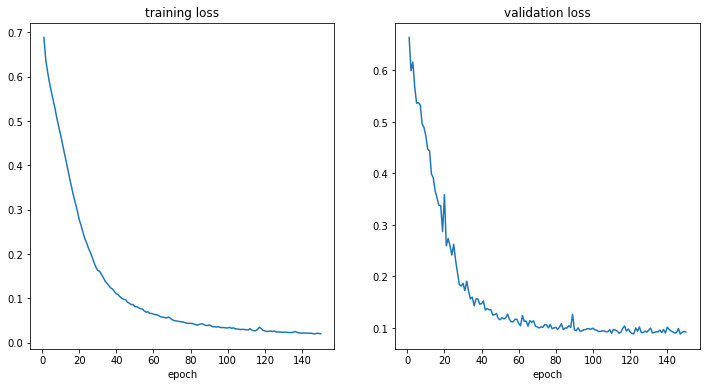

In [ ]:
# plot training and validation loss
plt.figure('', (12, 6))

plt.subplot(1, 2, 1)
plt.title("training loss")
x = [i + 1 for i in range(len(train_loss))]
y = train_loss
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(1, 2, 2)
plt.title("validation loss")
val_interval=1
x = [val_interval * (i + 1) for i in range(len(val_loss))]
y = val_loss
plt.xlabel("epoch")
plt.plot(x, y)
plt.show() 

In [ ]:
# save trained model
os.chdir('/content/drive/My Drive/COLAB/DL_3D_MIA_project/models')

# uncomment torch.save if you want to save the model that you just trained,
# otherwise use torch.load to load the model
# if saving: change date and time when saving model, e.g. 20220615_1230_model_main_DCNN_ED
# torch.save(model.state_dict(), r'20220701_1526_model_main_DCNN_ED.pt')
PATH = r'20220701_1526_model_main_DCNN_ED.pt'
model.load_state_dict(torch.load(PATH))


<All keys matched successfully>

# Visual evaluation of trained network


In [ ]:
def visual_evaluation(sample, model):
    """
    Allow the visual inspection the result of one sample by plotting 
    the image, the ground truth (left) and the segmentation map produced by the network (right).
    
    Args:
        sample (Dict[str, torch.Tensor]): sample composed of an image ('img') and a mask ('mask').
        model (torch.nn.Module): trained model to evaluate.
    """
    model.eval()
    inferer = monai.inferers.SimpleInferer()
    discrete_transform = monai.transforms.AsDiscrete(logit_thresh=0.5, threshold_values=True)
    with torch.no_grad():
        output = inferer(inputs=sample['img'].to(device), network=model).cpu().squeeze()
        output = discrete_transform(output)
    
    mask = np.squeeze(sample['mask'])

    # # plot predicted segmentation
    # plt.figure()
    # plt.imshow(output[3,:,:])
    # plt.show()

    # fig, ax = plt.subplots(1,2, figsize = [12, 10])
    
    # # Plot image and ground truth
    # overlay_mask = np.ma.masked_where(mask == 0, mask == 1)
    # ax[0].imshow(sample["img"].squeeze(), 'gray')
    # ax[0].imshow(overlay_mask[3,:,:], 'Greens', alpha = 0.7, clim=[0,1], interpolation='nearest')
    # ax[0].set_title('Ground truth')
    # # Plot image and predicted segmentation
    # overlay_output = np.ma.masked_where(output < 0.1, output >0.99)
    # ax[1].imshow(sample['img'].squeeze(), 'gray')
    # ax[1].imshow(overlay_output[3,:,:], 'Greens', alpha = 0.7, clim=[0,1])
    # ax[1].set_title('Prediction')
    # plt.show()

    return output, mask

In [ ]:
# create new val_dataloader with batch_size=1
val_dataloader_evaluation = monai.data.DataLoader(val_dataset_2D, batch_size=1)

print('Number of patients: ', len(validation_patient))
print('Length of validation dataset: ', len(val_dataloader_evaluation))

output_val = []
mask_val = []
for i, sample in enumerate(val_dataloader_evaluation):
    # print('patient number: ', validation_patient[i])
    output_sample, mask_sample = visual_evaluation(sample, model)
    output_val.append(output_sample)
    mask_val.append(mask_sample)

# SAME FOR TRAINING DATASET
# create new val_dataloader with batch_size=1
train_dataloader_evaluation = monai.data.DataLoader(train_dataset_2D, batch_size=1)

print('Number of patients: ', len(train_patient))
print('Length of validation dataset: ', len(train_dataloader_evaluation))

output_train = []
mask_train = []
for i, sample in enumerate(train_dataloader_evaluation):
    # print('patient number: ', validation_patient[i])
    output_sample, mask_sample = visual_evaluation(sample, model)
    output_train.append(output_sample)
    mask_train.append(mask_sample)


Number of patients:  20
Length of validation dataset:  181


/usr/local/lib/python3.7/dist-packages/monai/transforms/post/array.py:181: UserWarning: `threshold_values=True/False` is deprecated, please use `threshold=value` instead.
  warnings.warn("`threshold_values=True/False` is deprecated, please use `threshold=value` instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Number of patients:  80
Length of validation dataset:  681


# Create 3D volume from 2D predicitons

In [ ]:
# compute number of slices per patient in validation and train dataset
nb_slices_per_patient_val=[]

i=0
for sample in val_dataset_transformed:
    i=i+1
    image = sample["img"]
    nb_slices = sample['img'].shape[3]
    nb_slices_per_patient_val.append(nb_slices)
    print(i, ": Image size: ", image.shape)

print('Number of slices per patient in validation dataset: ', nb_slices_per_patient_val)
print('Sum of number of slices: ', np.sum(nb_slices_per_patient_val))  # check whether this is the same as the size of the 2D validation dataset

# SAME FOR TRAINING DATASET
nb_slices_per_patient_train=[]

i=0
for sample in train_dataset_transformed:
    i=i+1
    image = sample["img"]
    nb_slices = sample['img'].shape[3]
    nb_slices_per_patient_train.append(nb_slices)
    # print(i, ": Image size: ", image.shape)


1 : Image size:  (1, 190, 233, 6)
2 : Image size:  (1, 214, 253, 8)
3 : Image size:  (1, 200, 267, 10)
4 : Image size:  (1, 267, 225, 9)
5 : Image size:  (1, 217, 267, 8)
6 : Image size:  (1, 206, 253, 10)
7 : Image size:  (1, 208, 247, 9)
8 : Image size:  (1, 169, 247, 9)
9 : Image size:  (1, 214, 253, 9)
10 : Image size:  (1, 225, 267, 10)
11 : Image size:  (1, 208, 247, 11)
12 : Image size:  (1, 214, 253, 10)
13 : Image size:  (1, 267, 267, 8)
14 : Image size:  (1, 233, 267, 10)
15 : Image size:  (1, 187, 233, 8)
16 : Image size:  (1, 240, 203, 10)
17 : Image size:  (1, 201, 240, 8)
18 : Image size:  (1, 197, 233, 8)
19 : Image size:  (1, 208, 247, 10)
20 : Image size:  (1, 250, 267, 10)
Number of slices per patient in validation dataset:  [6, 8, 10, 9, 8, 10, 9, 9, 9, 10, 11, 10, 8, 10, 8, 10, 8, 8, 10, 10]
Sum of number of slices:  181


In [ ]:
# create 3D volumes from 2D slices for each patient
output_val_3D = []
mask_val_3D = []
index = 0
for i, patient_number in enumerate(validation_patient):
  output_val_3D_i = torch.tensor(np.zeros([4,128,128,nb_slices_per_patient_val[i]]))
  mask_val_3D_i = torch.tensor(np.zeros([4,128,128,nb_slices_per_patient_val[i]]))
  for slice_i in range(nb_slices_per_patient_val[i]):
    output_val_3D_i[:,:,:,slice_i] = output_val[index]
    mask_val_3D_i[:,:,:,slice_i] = mask_val[index]
    index=index+1
  output_val_3D.append(output_val_3D_i)
  mask_val_3D.append(mask_val_3D_i)

# SAME FOR TRAINING DATASET
output_train_3D = []
mask_train_3D = []
index = 0
for i, patient_number in enumerate(train_patient):
  output_train_3D_i = torch.tensor(np.zeros([4,128,128,nb_slices_per_patient_train[i]]))
  mask_train_3D_i = torch.tensor(np.zeros([4,128,128,nb_slices_per_patient_train[i]]))
  for slice_i in range(nb_slices_per_patient_train[i]):
    output_train_3D_i[:,:,:,slice_i] = output_train[index]
    mask_train_3D_i[:,:,:,slice_i] = mask_train[index]
    index=index+1
  output_train_3D.append(output_train_3D_i)
  mask_train_3D.append(mask_train_3D_i)

# Compute metrics on 3D prediction crops
metrics: Dice similarity coefficient and Hausdorff distance

In [ ]:
metric_dice = monai.metrics.compute_meandice
metric_hausdorff = monai.metrics.compute_hausdorff_distance

dice_val = []
hausdorff_val = []
for i in range(len(validation_patient)):
  nb_slices = output_val_3D[i].shape[3]
  output = torch.Tensor(np.zeros([1,4,128,128,nb_slices]))
  output[0,:,:,:,:] = output_val_3D[i]
  mask = torch.Tensor(np.zeros([1,4,128,128,nb_slices]))
  mask[0,:,:,:,:] = mask_val_3D[i]

  dice_i = metric_dice(output, mask, include_background=False)
  dice_val.append(dice_i)
  hausdorff_i = metric_hausdorff(output, mask, include_background=False)
  hausdorff_i = hausdorff_i*1.5 # compute Hausdorff distance in mm instead of pixels
                                # since pixdim was (1.5, 1.5, 10) in Spacingd transform -> multiply with 1.5
  hausdorff_val.append(hausdorff_i)

# SAME FOR TRAINING DATASET
dice_train = []
hausdorff_train = []
for i in range(len(train_patient)):
  nb_slices = output_train_3D[i].shape[3]
  output = torch.Tensor(np.zeros([1,4,128,128,nb_slices]))
  output[0,:,:,:,:] = output_train_3D[i]
  mask = torch.Tensor(np.zeros([1,4,128,128,nb_slices]))
  mask[0,:,:,:,:] = mask_train_3D[i]

  dice_i = metric_dice(output, mask, include_background=False)
  dice_train.append(dice_i)
  hausdorff_i = metric_hausdorff(output, mask, include_background=False)
  hausdorff_i = hausdorff_i*1.5 # compute Hausdorff distance in mm instead of pixels
                                # since pixdim was (1.5, 1.5, 10) in Spacingd transform -> multiply with 1.5
  hausdorff_train.append(hausdorff_i)

In [ ]:
# compute mean Dice and Hausdorff for validation and training dataset
dice_label1_cumulative=0
dice_label2_cumulative=0
dice_label3_cumulative=0
hausdorff_label1_cumulative=0
hausdorff_label2_cumulative=0
hausdorff_label3_cumulative=0
for i in range(len(dice_val)):
  dice_label1_cumulative = dice_label1_cumulative+dice_val[i][0][0]
  dice_label2_cumulative = dice_label2_cumulative+dice_val[i][0][1]
  dice_label3_cumulative = dice_label3_cumulative+dice_val[i][0][2]
  hausdorff_label1_cumulative = hausdorff_label1_cumulative+hausdorff_val[i][0][0]
  hausdorff_label2_cumulative = hausdorff_label2_cumulative+hausdorff_val[i][0][1]
  hausdorff_label3_cumulative = hausdorff_label3_cumulative+hausdorff_val[i][0][2]

dice_label1_val = dice_label1_cumulative/len(dice_val)
dice_label2_val = dice_label2_cumulative/len(dice_val)
dice_label3_val = dice_label3_cumulative/len(dice_val)
hausdorff_label1_val = hausdorff_label1_cumulative/len(hausdorff_val)
hausdorff_label2_val = hausdorff_label2_cumulative/len(hausdorff_val)
hausdorff_label3_val = hausdorff_label3_cumulative/len(hausdorff_val)

print('Metrics for validation dataset: ')
print('Mean Dice similarity coefficient for label 1 (right ventricle): ', dice_label1_val.numpy())
print('Mean Dice similarity coefficient for label 2 (myocardium): ', dice_label2_val.numpy())
print('Mean Dice similarity coefficient for label 3 (left ventricle): ', dice_label3_val.numpy())
print('Mean Hausdorff distance (mm) for label 1 (right ventricle): ', hausdorff_label1_val.numpy())
print('Mean Hausdorff distance (mm) for label 2 (myocardium): ', hausdorff_label2_val.numpy())
print('Mean Hausdorff distance (mm) for label 3 (left ventricle): ', hausdorff_label3_val.numpy())

# SAME FOR TRAINING DATASET
dice_label1_cumulative=0
dice_label2_cumulative=0
dice_label3_cumulative=0
hausdorff_label1_cumulative=0
hausdorff_label2_cumulative=0
hausdorff_label3_cumulative=0
for i in range(len(dice_train)):
  dice_label1_cumulative = dice_label1_cumulative+dice_train[i][0][0]
  dice_label2_cumulative = dice_label2_cumulative+dice_train[i][0][1]
  dice_label3_cumulative = dice_label3_cumulative+dice_train[i][0][2]
  hausdorff_label1_cumulative = hausdorff_label1_cumulative+hausdorff_train[i][0][0]
  hausdorff_label2_cumulative = hausdorff_label2_cumulative+hausdorff_train[i][0][1]
  hausdorff_label3_cumulative = hausdorff_label3_cumulative+hausdorff_train[i][0][2]

dice_label1_train = dice_label1_cumulative/len(dice_train)
dice_label2_train = dice_label2_cumulative/len(dice_train)
dice_label3_train = dice_label3_cumulative/len(dice_train)
hausdorff_label1_train = hausdorff_label1_cumulative/len(hausdorff_train)
hausdorff_label2_train = hausdorff_label2_cumulative/len(hausdorff_train)
hausdorff_label3_train = hausdorff_label3_cumulative/len(hausdorff_train)

print('Metrics for training dataset: ')
print('Mean Dice similarity coefficient for label 1 (right ventricle): ', dice_label1_train.numpy())
print('Mean Dice similarity coefficient for label 2 (myocardium): ', dice_label2_train.numpy())
print('Mean Dice similarity coefficient for label 3 (left ventricle): ', dice_label3_train.numpy())
print('Mean Hausdorff distance (mm) for label 1 (right ventricle): ', hausdorff_label1_train.numpy())
print('Mean Hausdorff distance (mm) for label 2 (myocardium): ', hausdorff_label2_train.numpy())
print('Mean Hausdorff distance (mm) for label 3 (left ventricle): ', hausdorff_label3_train.numpy())

Metrics for validation dataset: 
Mean Dice similarity coefficient for label 1 (right ventricle):  0.87312
Mean Dice similarity coefficient for label 2 (myocardium):  0.8291216
Mean Dice similarity coefficient for label 3 (left ventricle):  0.94955033
Mean Hausdorff distance (mm) for label 1 (right ventricle):  56.192806569036335
Mean Hausdorff distance (mm) for label 2 (myocardium):  46.437380860903396
Mean Hausdorff distance (mm) for label 3 (left ventricle):  27.050428688938297
Metrics for training dataset: 
Mean Dice similarity coefficient for label 1 (right ventricle):  0.98110616
Mean Dice similarity coefficient for label 2 (myocardium):  0.96390945
Mean Dice similarity coefficient for label 3 (left ventricle):  0.9904547
Mean Hausdorff distance (mm) for label 1 (right ventricle):  13.670580117998185
Mean Hausdorff distance (mm) for label 2 (myocardium):  30.135450517480667
Mean Hausdorff distance (mm) for label 3 (left ventricle):  3.9433826012135333


# Visualize results for paper

In [ ]:
mean_dice = []
for i in range(len(dice_val)):
  mean_dice.append(np.mean(dice_val[i][0].numpy()))

print(mean_dice)

dice_min = np.min(mean_dice)
index_dice_min = np.where(mean_dice == np.amin(mean_dice))
print('Index ', index_dice_min[0], ' has minimal mean dice value ', dice_min)

dice_max = np.max(mean_dice)
index_dice_max = np.where(mean_dice == np.amax(mean_dice))
print('Index ', index_dice_max[0], ' has maximal mean dice value ', dice_max)

[0.8132152, 0.8265582, 0.89599484, 0.89985937, 0.875807, 0.8985042, 0.8498438, 0.8755757, 0.8813221, 0.86213034, 0.9304959, 0.886184, 0.96236634, 0.8389612, 0.8390333, 0.86515325, 0.90844303, 0.944905, 0.91034913, 0.9139102]
Index  [0]  has minimal mean dice value  0.8132152
Index  [12]  has maximal mean dice value  0.96236634


torch.Size([4, 128, 128, 6])
torch.Size([4, 128, 128, 8])


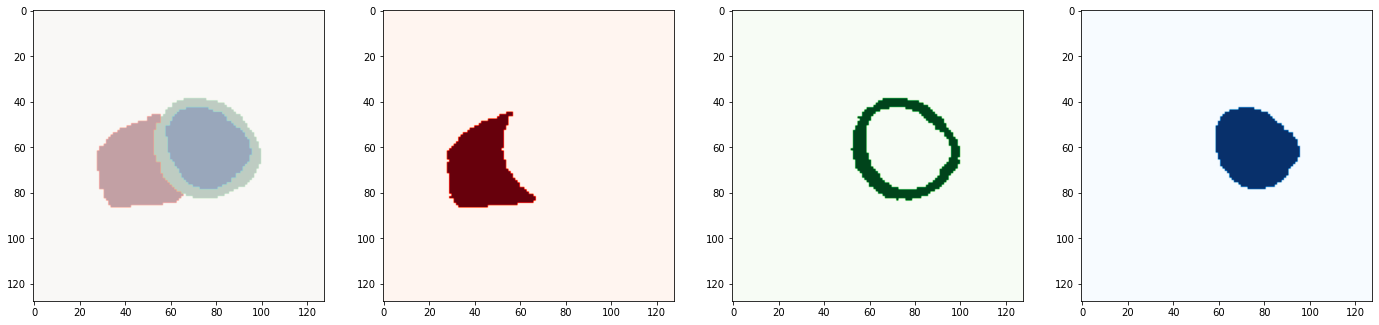

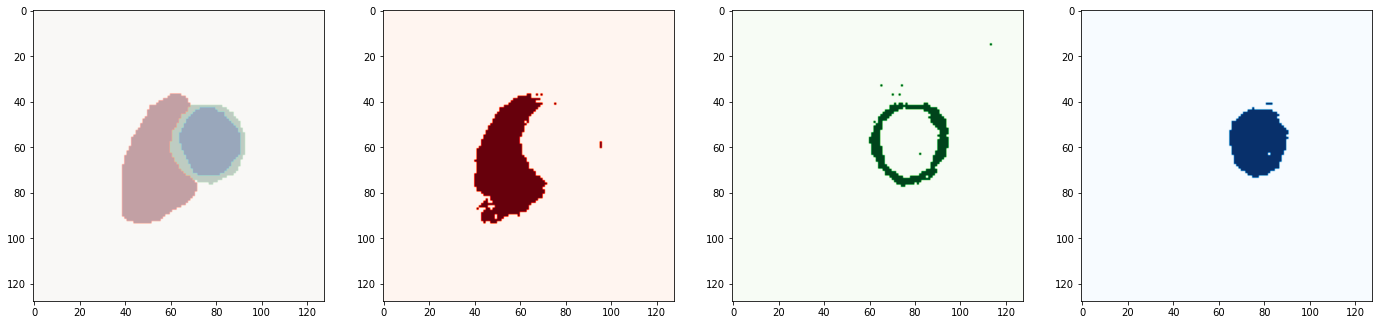

In [ ]:

print(output_val_3D[0].shape)
print(output_val_3D[12].shape)



# best prediction
fig = plt.figure(figsize=(24, 24))

plt.subplot(2, 4, 1)
plt.imshow(np.transpose(mask_val_3D[12][1,:,:,4]), cmap='Reds')
plt.imshow(np.transpose(mask_val_3D[12][2,:,:,4]), cmap='Greens', alpha = 0.4, clim=[0,1])
plt.imshow(np.transpose(mask_val_3D[12][3,:,:,4]), cmap='Blues', alpha = 0.4, clim=[0,1])
plt.subplot(2, 4, 2)
plt.imshow(np.transpose(output_val_3D[12][1,:,:,4]), cmap='Reds')
# plt.imshow(np.transpose(mask_val_3D[12][1,:,:,3]), 'Reds', alpha = 0.2, clim=[0,1])
plt.subplot(2, 4, 3)
plt.imshow(np.transpose(output_val_3D[12][2,:,:,4]), cmap='Greens')
plt.subplot(2, 4, 4)
plt.imshow(np.transpose(output_val_3D[12][3,:,:,4]), cmap='Blues')

# worst prediction
fig = plt.figure(figsize=(24, 24))

plt.subplot(2, 4, 1)
plt.imshow(np.transpose(mask_val_3D[0][1,:,:,2]), cmap='Reds')
plt.imshow(np.transpose(mask_val_3D[0][2,:,:,2]), cmap='Greens', alpha = 0.4, clim=[0,1])
plt.imshow(np.transpose(mask_val_3D[0][3,:,:,2]), cmap='Blues', alpha = 0.4, clim=[0,1])
plt.subplot(2, 4, 2)
plt.imshow(np.transpose(output_val_3D[0][1,:,:,2]), cmap='Reds')
plt.subplot(2, 4, 3)
plt.imshow(np.transpose(output_val_3D[0][2,:,:,2]), cmap='Greens')
plt.subplot(2, 4, 4)
plt.imshow(np.transpose(output_val_3D[0][3,:,:,2]), cmap='Blues')

